In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder   
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load all of the necessary dataset
try:
    results = pd.read_csv('results.csv')
    races = pd.read_csv('races.csv')
    drivers = pd.read_csv('drivers.csv')
    drivers_standings = pd.read_csv('driver_standings.csv')
    constructors = pd.read_csv('constructors.csv')
    constructors_standings = pd.read_csv('constructor_standings.csv')
    constructors_results = pd.read_csv('constructor_results.csv')

# Check are the dataset loaded correctly
    print("All datasets loaded successfully.")
except fileNotFoundError as e:
    print(f"Error loading datasets: {e}")

All datasets loaded successfully.


In [4]:
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# Merge result with races 
df = pd.merge(results, races[['raceId', 'year', 'round', 'circuitId']], on='raceId', how='left')

# Convert 'position' to numeric, forcing errors to NaN
df['position_numeric'] = pd.to_numeric(df['position'], errors='coerce')

# Because we are focusing on the drivers who finished so dnfs are excluded
df = df.dropna(subset=['position_numeric']) # drop the drivers who did not finish
df['position_numeric'] = df['position_numeric'].astype(int)

# create a target variable 'finished_in_top_10'
df['finished_in_top_10'] = np.where(df['position_numeric'] <= 10, 1, 0)

# cleaning the dataset by removing unnecessary columns
df = df.drop(columns='position', axis=1) 


In [6]:
df.head()

,resultId,raceId,driverId,constructorId,number,grid,positionText,positionOrder,points,laps,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,position_numeric,finished_in_top_10
0,1,18,1,1,22,1,1,1,10.0,58,...,39,2,1:27.452,218.3,1,2008,1,1,1,1
1,2,18,2,2,3,5,2,2,8.0,58,...,41,3,1:27.739,217.586,1,2008,1,1,2,1
2,3,18,3,3,7,7,3,3,6.0,58,...,41,5,1:28.090,216.719,1,2008,1,1,3,1
3,4,18,4,4,5,11,4,4,5.0,58,...,58,7,1:28.603,215.464,1,2008,1,1,4,1
4,5,18,5,1,23,3,5,5,4.0,58,...,43,1,1:27.418,218.385,1,2008,1,1,5,1


In [7]:
# Add new features from drivers_standings
# Rename columns to avoid confusion during merge
drivers_standings_renamed = drivers_standings[['raceId', 'driverId', 'points', 'position']]
drivers_standings_renamed = drivers_standings_renamed.rename(columns={'points': 'driver_total_points_after_race'})

constructors_standings_renamed = constructors_standings[['raceId', 'constructorId', 'points']]
constructors_standings_renamed = constructors_standings_renamed.rename(columns={'points': 'constructor_total_points after_race'})

# Merge standings data
df = pd.merge(df, drivers_standings_renamed, on=['raceId', 'driverId'], how='left')
df = pd.merge(df, constructors_standings_renamed, on=['raceId', 'constructorId'], how='left')

# Add filter modern era data from 2014 onwards
print(f"Real Data: {len(df)}")
df_modern_era = df[df['year'] >= 2014].copy()
print(f"Modern Era Data (2014 onwards): {len(df_modern_era)}")

# create the lagged "recent results" features
# sort by time to ensure correct lagging
df_modern_era = df_modern_era.sort_values(by=['year', 'round'])

# Group by driver/constructor so the 'shift' works correctly
df_modern_era['driver_points_before_race'] = df_modern_era.groupby('driverId')['driver_total_points_after_race'].shift(1)
df_modern_era['constructor_points_before_race'] = df_modern_era.groupby('constructorId')['constructor_total_points after_race'].shift(1)

# shift(1) will leave NaN for the first race of each driver/constructor
# fill NaN with 0, assuming no points before their first race
df_modern_era['driver_points_before_race'] = df_modern_era['driver_points_before_race'].fillna(0)
df_modern_era['constructor_points_before_race'] = df_modern_era['constructor_points_before_race'].fillna(0)

# Clean the 'grid' qualifying position feature
# 0 in 'grid' means the driver did not participate in qualifying or started from the back
# starting position is important, so we will keep these as is 
df_modern_era['grid'] = df_modern_era['grid'].replace(0, 20) 

print("Filter era for 2014 onwards and added recent performance features completed.")

Real Data: 16205
Modern Era Data (2014 onwards): 4304
Filter era for 2014 onwards and added recent performance features completed.


In [8]:
# add new features (recent perform) to improve accuracy score
df_modern_era['point_scored'] = df_modern_era.groupby('driverId')['driver_total_points_after_race'].diff().fillna(0)

# Count average points for the last 3 races
df_modern_era['driver_avg_points_last_3'] = df_modern_era.groupby('driverId')['point_scored'].shift(1).rolling(window=3, min_periods=1).mean().fillna(0)

# Circuit history performance
df_modern_era['driver_avg_points_circuit'] = df_modern_era.groupby(['driverId', 'circuitId'])['point_scored'].shift(1).expanding().mean().fillna(12)

print("Added additional recent performance features completed.")

Added additional recent performance features completed.


In [9]:
df_modern_era.head()

,resultId,raceId,driverId,constructorId,number,grid,positionText,positionOrder,points,laps,...,position_numeric,finished_in_top_10,driver_total_points_after_race,position,constructor_total_points after_race,driver_points_before_race,constructor_points_before_race,point_scored,driver_avg_points_last_3,driver_avg_points_circuit
11900,22130,900,3,131,6,3,1,1,25.0,57,...,1,1,25.0,1,25.0,0.0,0.0,0.0,0.0,12.0
11901,22131,900,825,1,20,4,2,2,18.0,57,...,2,1,18.0,2,33.0,0.0,0.0,0.0,0.0,12.0
11902,22132,900,18,1,22,10,3,3,15.0,57,...,3,1,15.0,3,33.0,0.0,33.0,0.0,0.0,12.0
11903,22133,900,4,6,14,5,4,4,12.0,57,...,4,1,12.0,4,18.0,0.0,0.0,0.0,0.0,12.0
11904,22134,900,822,3,77,15,5,5,10.0,57,...,5,1,10.0,5,10.0,0.0,0.0,0.0,0.0,12.0


In [10]:
# Split the data into features and target variable
features = ['grid', 'circuitId', 'constructorId', 'driver_points_before_race', 'constructor_points_before_race', 'driver_avg_points_last_3', 'driver_avg_points_circuit']
target = 'finished_in_top_10'

# add 'year' and do temporal train-test split
model_df = df_modern_era[features + [target, 'year']].dropna()

# train on all data except the last year
latest_year = model_df['year'].max()
print(f"Splitting data with latest year as {latest_year}, testing on {latest_year}")

# train set is all years except the latest
train_df = model_df[model_df['year'] < latest_year]

# test set is only the latest year
test_df = model_df[model_df['year'] == latest_year]

print(f"Training on {len(train_df)} races, testing on {len(test_df)} races.")

Splitting data with latest year as 2025, testing on 2025
Training on 3905 races, testing on 399 races.


Preprocessing

In [11]:
# Identify categorical features for one-hot encoding
categorical_features = ['circuitId', 'constructorId']

# Apply one-hot encoding to categorical features
X_train_unaligned = pd.get_dummies(train_df[features], columns=categorical_features, drop_first=True)
y_train = train_df[target]

X_test_unaligned = pd.get_dummies(test_df[features], columns=categorical_features, drop_first=True)
y_test = test_df[target]

# Align the train and test sets to have the same columns
# 'join = inner' ensures we only keep columns present in both sets
X_train, X_test = X_train_unaligned.align(X_test_unaligned, join='inner', axis=1, fill_value=0)

print(f"Training features shape: {X_train.shape}, Testing features shape: {X_test.shape}")
print(f"After allignment, model has {len(X_train.columns)} features.")

Training features shape: (3905, 33), Testing features shape: (399, 33)
After allignment, model has 33 features.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
--- Best Model Evaluation for 2025 season ---
Accuracy Score : 79.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       199
           1       0.79      0.81      0.80       200

    accuracy                           0.79       399
   macro avg       0.79      0.79      0.79       399
weighted avg       0.79      0.79      0.79       399


Confusion Matrix:
Best parameters from Grid Search: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
--- Best Model Evaluation for 2025 season ---
Accuracy Score : 79.45%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       199
           1       0.79      0.81      0.80       200



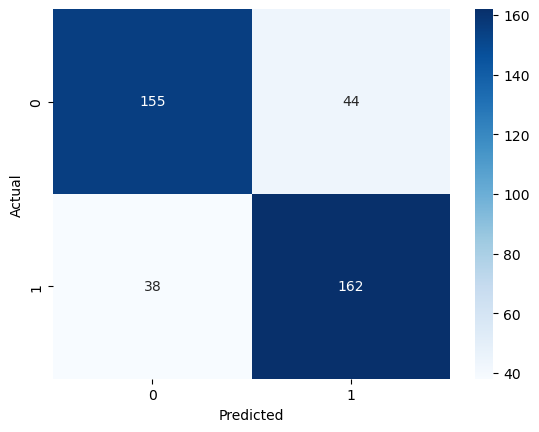

In [12]:
# Hyperparameter tuning can be added here for better model performance
from sklearn.model_selection import GridSearchCV

# Parameter grid for RandomForest
param_grid = {
    'n_estimators': [150, 250, 350],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Train the model 
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# cv = 3 for quicker tuning; increase for better results
# n_jobs = -1 to use all processors
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from grid search
print(f"Best parameters from Grid Search: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

# make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model performance
print(f"--- Best Model Evaluation for {latest_year} season ---")
print(f"Accuracy Score : {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

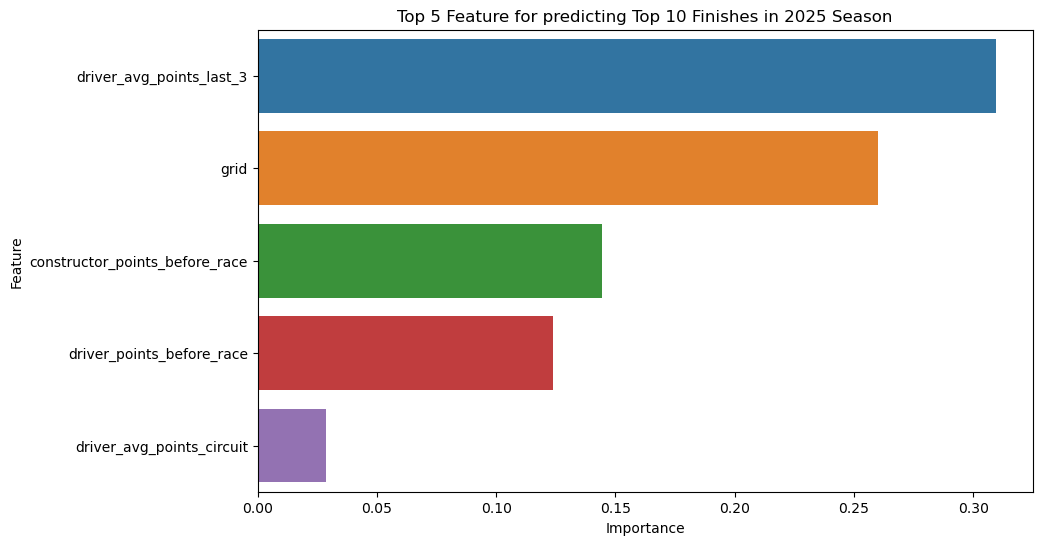

In [19]:
# Get feature importances from the trained model
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(5))
plt.title(f"Top 5 Feature for predicting Top 10 Finishes in {latest_year} Season")
plt.show()

Predicting next Grand Prix on 2025

In [20]:
# Create helpor function to predict next Grand Prix
historical_avg_finish = df_modern_era.groupby(['driverId','circuitId'])['position_numeric'].mean().reset_index()
historical_avg_finish = historical_avg_finish.rename(columns={'position_numeric': 'historical_avg_finish_lookup'})

print(f"Helper 'historical_avg_finish' created")

Helper 'historical_avg_finish' created


In [15]:
print("\nlist of constructors in the dataset:")
# showing relevant constructors (for example, active ones)
constructor_names = ['Red Bull', 'Ferrari', 'Mercedes', 'McLaren', 'Aston Martin', 'Alpine F1 Team', 'Williams', 'Haas F1 Team', 'Sauber', 'RB F1 Team']
relevant_constructors = constructors[constructors['name'].isin(constructor_names)]
print(relevant_constructors[['constructorId', 'name']])


list of constructors in the dataset:
     constructorId            name
0                1         McLaren
2                3        Williams
5                6         Ferrari
8                9        Red Bull
14              15          Sauber
115            117    Aston Martin
129            131        Mercedes
207            210    Haas F1 Team
210            214  Alpine F1 Team
211            215      RB F1 Team


# Driver IDs for 2025 & Average point last 3 races (SG,US,MEX)
- 1 = Lewis Hamilton = 4 + 12 + 4 = 6.6
- 4 = Fernando Alonso = 0 + 1 + 6 = 2.3
- 807 = Nico Hülkenberg = 0 + 4 + 0 = 1.3 
- 830 = Max Verstappen = 15 + 25 + 18 = 19.3
- 832 = Carlos Sainz = 0 + 0 + 1 = 0.3
- 839 = Esteban Ocon = 2 + 0 + 0 = 0.6
- 840 = Lance Stroll = 0 + 0 + 0 = 0
- 842 = Pierre Gasly = 0 + 0 + 0  = 0
- 844 = Charles Leclerc = 18 + 15 + 8 = 13.6
- 846 = Lando Norris = 25 + 18 + 15 = 19.3
- 847 = George Russell = 6 + 8 + 25 = 13
- 848 = Alexander Albon = 0 + 0 + 0 = 0
- 852 = Yuki Tsunoda = 0 + 6 + 0 = 2
- 857 = Oscar Piastri = 10 + 10 + 12 = 10.6
- 859 = Liam Lawson = 0 + 0 + 0 = 0
- 860 = Oliver Bearman = 12 + 2 + 2 = 5.3
- 861 = Franco Colapinto = 0 + 0 + 0 = 0
- 862 = Jack Doohan = 0 + 0 + 0 = 0
- 863 = Andrea Kimi Antonelli = 8 + 0 + 10 = 6
- 864 = Gabriel Bortoleto = 1 + 0 + 0 = 0.3
- 865 = Isack Hadjar = 0 + 0 + 0 = 0

In [16]:
# Color each of driver
DRIVER_C = {
    1:"#FF0000", 4:"#2E8B57", 807:"#00FF00", 830:"#0000B0", 832:"#007FFE", 839:"#191919", 
    840:"#2E8B57", 842:"#FF69B4", 844:"#FF0000", 846:"#FE7F00", 847:"#00CACA", 848:"#007FFE", 
    852:"#0000B0", 857:"#FE7F00", 859:"#7B68EE", 860:"#191919", 861:"#FF69B4", 
    862:"#FF69B4", 863:"#00CACA", 864:"#00FF00", 865:"#7B68EE"
}

# Drivers 2025 Data
drivers_2025 = ['Norris','Piastri','Verstappen','Russell','Leclerc','Hamilton','Antonelli',
                'Albon','Hulkenberg','Hadjar','Sainz','Alonso','Bearman','Stroll','Lawson',
                'Ocon','Tsunoda','Gasly','Bortoleto','Colapinto','Doohan'
]

predict_data = {
    'grid': [1, 2, 3 ,4 ,5 ,6 ,7 , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 ,21],
    'circuitId': [18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 ,18 , 18],
    'constructorId': [1, 1, 9, 131, 6, 6, 131, 3, 15, 215, 3, 117, 210, 117, 215, 210, 215, 214, 15, 214, 214],
    'driverId_for_lookup': [846, 857, 830, 847, 844, 1, 864, 848, 807, 865, 832, 4, 860, 840, 859, 839, 852, 842, 864, 861, 862],
    'driver_points_before_race': [357, 356, 321, 258, 210, 146, 97, 73, 41, 39, 38, 37, 32, 32, 30, 30, 28, 28, 19, 0, 0],
    'constructor_points_before_race': [713, 713, 346, 355, 356, 356, 355, 111, 60, 72, 111, 69, 62, 69, 72, 62, 346, 20, 60, 20, 20],
    'driver_avg_points_last_3': [19.3, 10.6, 19.3, 13, 13.6, 6.6, 6, 0, 1.3, 0, 0.3, 2.3, 5.3, 0, 0, 0.6, 2, 0, 0.3, 0, 0],
}
X_pred_raw = pd.DataFrame(predict_data)

# Combine X_pred_raw with historical_avg_finish to get circuit history feature
X_pred_raw = pd.merge(
    X_pred_raw, 
    historical_avg_finish[historical_avg_finish['circuitId'] == 18],
    left_on='driverId_for_lookup', 
    right_on='driverId', 
    how='left'
)

# Change name of the historical_avg_finish_lookup column to match model feature
X_pred_raw['avg_finish_at_circuit'] = X_pred_raw['historical_avg_finish_lookup'].fillna(12.0)

# Delete unneeded helper columns 
X_pred_raw = X_pred_raw.drop(columns=['driverId_for_lookup','circuitId_y','driverId','historical_avg_finish_lookup'])
X_pred_raw = X_pred_raw.rename(columns={'circuitId_x': 'circuitId'})

# Preprocessing & Allignment using 'features' and 'categorical_features'
features = ['grid', 'circuitId', 'constructorId', 'driver_points_before_race', 'constructor_points_before_race', 'driver_avg_points_last_3', 'avg_finish_at_circuit']
categorical_features = ['circuitId', 'constructorId']

# Apply one-hot encoding to categorical features
X_pred_unaligned = pd.get_dummies(X_pred_raw[features], columns=categorical_features, drop_first=True)

# Align the prediction set with training set to have the same columns
X_pred_aligned = X_pred_unaligned.reindex(columns=X_train.columns, fill_value=0)

# Make predictions for the next Grand Prix
predictions = best_rf_model.predict(X_pred_aligned)
probabilities = best_rf_model.predict_proba(X_pred_aligned)

# Display predictions with driver names
results_df = pd.DataFrame({
    'Driver': drivers_2025,
    'Predicted_Top_10_Finish': predictions,
    'driverId' : predict_data['driverId_for_lookup'],
    'grid' : predict_data['grid'],
    'Probability_of_Top_10_Finish': (probabilities[:, 1] * 100).round(2)
})

# Make an exception for Doohan
results_df.loc[results_df['Driver'] == 'Doohan',  'Probability_of_Top_10_Finish'] = 0.0
results_df.loc[results_df['Driver'] == 'Doohan',  'Predicted__Top_10_Finish'] = 0

results_df['color'] = results_df['driverId'].map(DRIVER_C).fillna('#808080')

results_df_sorted = results_df.sort_values(by='Probability_of_Top_10_Finish', ascending=False)

print("Predictions top 10 finishes for the next Grand Prix (Brazil GP):")
print(results_df_sorted[['Driver', 'Predicted_Top_10_Finish', 'Probability_of_Top_10_Finish']])

Predictions top 10 finishes for the next Grand Prix (Brazil GP):
        Driver  Predicted_Top_10_Finish  Probability_of_Top_10_Finish
2   Verstappen                        1                         97.26
4      Leclerc                        1                         95.33
0       Norris                        1                         94.37
3      Russell                        1                         94.12
1      Piastri                        1                         93.31
6    Antonelli                        1                         91.45
5     Hamilton                        1                         91.26
12     Bearman                        1                         55.51
7        Albon                        1                         52.23
8   Hulkenberg                        1                         51.57
9       Hadjar                        0                         46.64
16     Tsunoda                        0                         39.67
10       Sainz           


 Graph the probabilities of Finishing in Top 10 Brazil GP 
 


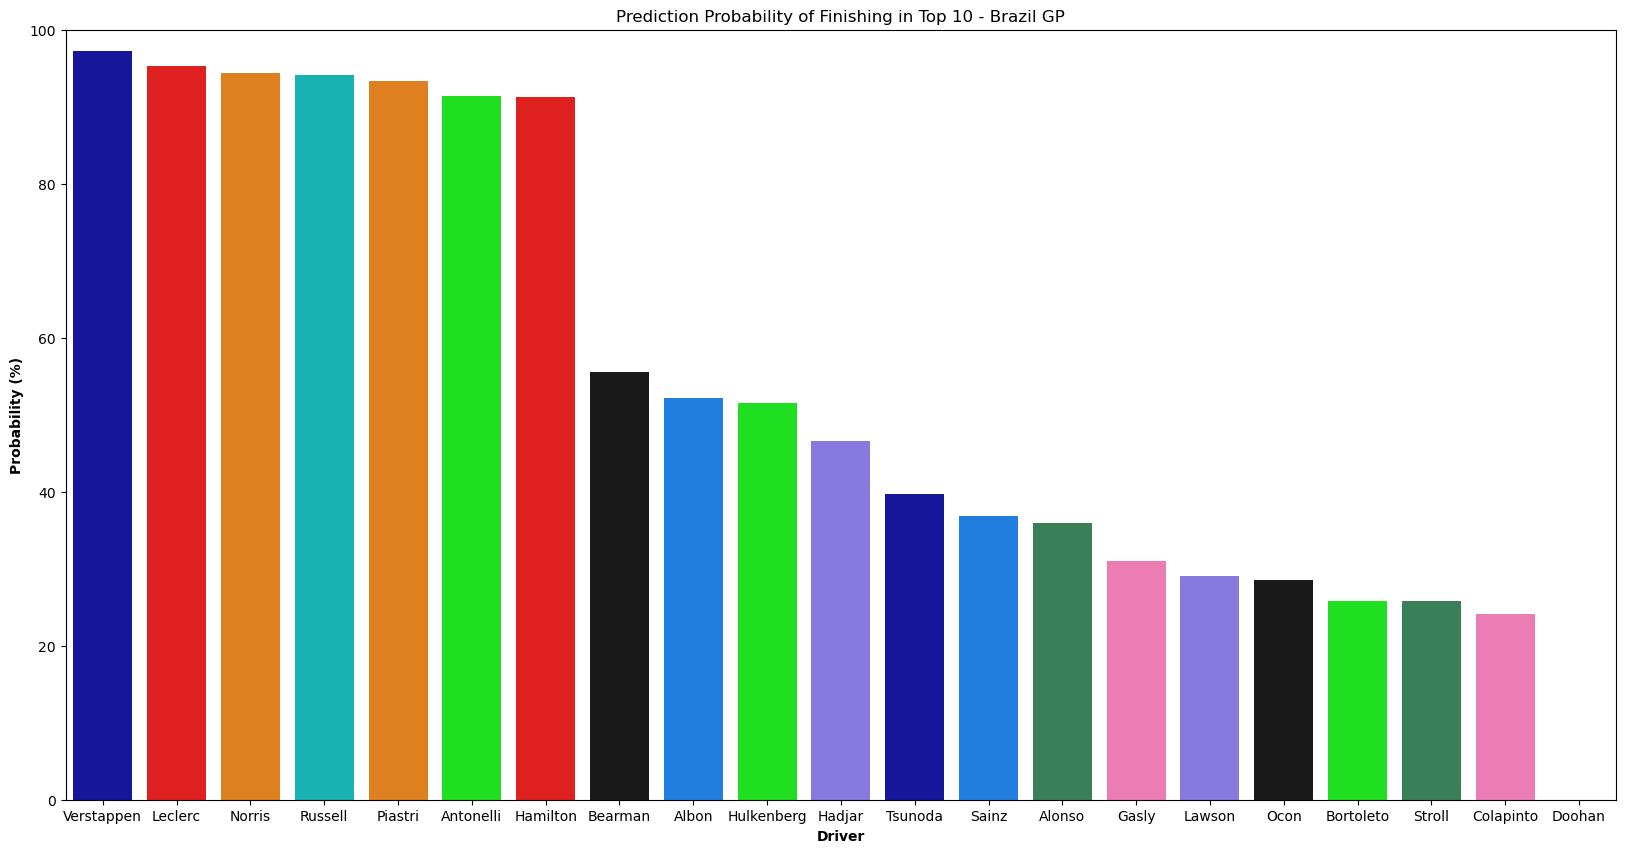

In [18]:
# Graph the probabilities

print("\n Graph the probabilities of Finishing in Top 10 Brazil GP \n ")
plt.figure(figsize=(20, 10))

sns.barplot(
    data=results_df_sorted,
    x='Driver', 
    y='Probability_of_Top_10_Finish', 
    palette = results_df_sorted['color']
)

plt.title('Prediction Probability of Finishing in Top 10 - Brazil GP')
plt.ylabel('Probability (%)', fontweight='bold')
plt.xlabel('Driver', fontweight='bold')
plt.ylim(0, 100)

plt.show()